
# Just some notes on week tasks

Databases

napedro_3mixed_human_yeast_ecoli_20140403_iRT_reverse.fasta

---
13366 sequences are shared in > 1 Proteins. (0.019425 of proteins. ))

674708 sequences has unique proteins.(0.980575 of proteins.))
 
30541 proteins in .FASTA

7107 proteins have shared peptides. (0.232704 of proteins. ))

---

UP00000625_UP000002311_UP000005640.fasta 

15167 sequences are shared in > 1 Proteins. (0.021746 of proteins. ))

682301 sequences has unique proteins.(0.978254 of proteins.))

31010 proteins in .FASTA

7564 proteins have shared peptides. (0.243921 of proteins. ))

---

Note to self: does not make sense to count protein with non-shared peptides this way because protein can contain both shared and non-shared peptides.

Peptide count 

experiments/20210607_count_shared_peptide_in_fasta.ipynb



Tasks run
- TTOF6600 32fix (DIA .mzML) --> DIAUmpire (SE) --> MSFragger (500 mz fragment tolerance) --> Database (napedro_3mixed_human_yeast_ecoli_20140403_iRT_reverse) --> diann --> triqler --> [triqler does not convert]
- TTOF6600 32fix (DIA .mzML) ---> DIAUmpire (SE) --> MSFragger (20 mz fragment tolerance) --> Database (napedro_3mixed_human_yeast_ecoli_20140403_iRT_reverse) --> diann --> triqler --> OK!
- TTOF6600 32fix (DDA .mzML) --> MSFragger (20 mz fragment tolerance) --> EasyPQP --> spectral library --> OSW (EasyPQP finished... start OSW on this.)

Tested run without ProteinProphet --> We get error message saying we cannot run easyPQP without ProteinProphet.

Question: It it possible to use diann own decoy generator and have it output decoy proteins, when not supplying decoy from spectral library?

Dia-nn uses parsimony:
["For each precursor, DIA-NN aims to reduce the number of proteins associated with it using the maximum parsimony principle, which is implemented via a greedy set cover algorithm."](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6949130/)


What might cause the issue of high fragment tolerance? It find a lot less (about half of the protein found in low fragment 20mz)


# Fix
- Use -np.log(Q.value) to triqler and msqrob 
- Use PG.Quantity or PG.Normalized or Precursor.Quantity or Precursor.Normalized for triqler and msqrob as intensity?



# Peptide and protein count

In [153]:
# set fcs
fcs =  [round(i*0.04,2) for i in range(20)]
# Note NEED TO CHANGE TRIQLER RESULTS DIRECTORY BELOW TO READ IN FILES 

In [154]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [155]:

import os 
import pandas as pd
import numpy as np
# git 
os.chdir("/home/ptruong/git/dia_sum/scripts/PXD002952")
from triqler_output_to_df import parse_triqler
from q_value import qvalues


# db
from get_protein_specie_map_from_fasta import fasta_to_protein_specie_map
os.chdir("/home/ptruong/git/dia_sum/database")
protein_specie_map = fasta_to_protein_specie_map("2021-04-27-decoys-reviewed-contam-UP000005640-UP000002311-UP000000625.fas")
#protein_specie_map = protein_specie_map.set_index("protein").T.to_dict()
# MSFragger 
os.chdir("/hdd_14T/data/PXD002952/res_20210609_DIAUmpire/MSFragger/diann_reformatted_lib")


In [156]:
df = pd.read_csv("diann.tsv", sep = "\t")
triq = pd.read_csv("triqler_input_diann.csv", sep = "\t")                 

In [157]:
df.columns

Index(['File.Name', 'Run', 'Protein.Group', 'Protein.Ids', 'Protein.Names',
       'Genes', 'PG.Quantity', 'PG.Normalised', 'PG.MaxLFQ', 'Genes.Quantity',
       'Genes.Normalised', 'Genes.MaxLFQ', 'Genes.MaxLFQ.Unique',
       'Modified.Sequence', 'Stripped.Sequence', 'Precursor.Id',
       'Precursor.Charge', 'Q.Value', 'Global.Q.Value', 'Protein.Q.Value',
       'PG.Q.Value', 'Global.PG.Q.Value', 'GG.Q.Value', 'Translated.Q.Value',
       'Proteotypic', 'Precursor.Quantity', 'Precursor.Normalised',
       'Precursor.Translated', 'Quantity.Quality', 'RT', 'RT.Start', 'RT.Stop',
       'iRT', 'Predicted.RT', 'Predicted.iRT', 'Lib.Q.Value',
       'Ms1.Profile.Corr', 'Ms1.Area', 'Evidence', 'Spectrum.Similarity',
       'Mass.Evidence', 'CScore', 'Decoy.Evidence', 'Decoy.CScore',
       'Fragment.Quant.Raw', 'Fragment.Quant.Corrected',
       'Fragment.Correlations', 'MS2.Scan', 'IM', 'iIM', 'Predicted.IM',
       'Predicted.iIM'],
      dtype='object')

According to diann manual Lib.Q.Value is the global FDR (which should be the FDR for each precursor) and therefore this we should filter with.

In [184]:
def compute_diann_top3_submodule(df, run):
    df_run = df[df.Run == run]
    df_run = df_run[df_run["Q.Value"] < 0.01] # 0.01 FDR filter

    def diann_top3(df_run):
        res = df_run.groupby("Protein.Ids")["Precursor.Quantity"].apply(lambda x: x.nlargest(3).mean() if len(x.nlargest(3)) >= 2 else np.nan).reset_index()
        #df['Precursor.Quantity']
        return res

    def diann_printout_unique_peptides_proteins(run):
        #print(run)
        run_ = run.split("_")[5]
        condition_ = run.split("_")[8]
        print(f"run : {run_} - condition : {condition_}")
        print(f"Unique peptides detected: {len(df_run['Stripped.Sequence'].unique())}")
        print(f"Unique proteins detected: {len(df_run['Protein.Ids'].unique())}")
        print()

    diann_printout_unique_peptides_proteins(run)  
    res = diann_top3(df_run)
    
    sample_id = run.split("_")[8]
    experiment_id = run.split("_")[5]

    midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])

    def remove_decoy_tag_protein(protein):
        if protein.split("_")[0] == "DECOY":
            return protein.split("_")[1]
        else: return protein
    
    res["proteins_nonTagged"] = res["Protein.Ids"].map(remove_decoy_tag_protein)
    
    res = pd.concat([res, pd.DataFrame(res["proteins_nonTagged"].str.split("_").tolist(),
                                 columns = ['ProteinName','specie'])], axis = 1)
    
    res = res[~res["specie"].isna()]
    res.drop("proteins_nonTagged", axis = 1, inplace = True)
    res.drop("Protein.Ids", axis = 1, inplace = True)
    res["intensity"] = res["Precursor.Quantity"]
    res.drop("Precursor.Quantity", axis = 1, inplace = True)
    res = res.set_index(["specie", "ProteinName"])

    res = pd.DataFrame(res.values, columns = midx, index = res.index)
    return res

In [185]:
dfs = []
for run in df.Run.unique():
    dfs.append(compute_diann_top3_submodule(df, run))

run : 002-Pedro - condition : 1
Unique peptides detected: 33481
Unique proteins detected: 4319

run : 003-Pedro - condition : 2
Unique peptides detected: 33707
Unique proteins detected: 4340

run : 004-Pedro - condition : 1
Unique peptides detected: 33527
Unique proteins detected: 4342

run : 005-Pedro - condition : 2
Unique peptides detected: 33794
Unique proteins detected: 4327

run : 007-Pedro - condition : 2
Unique peptides detected: 33570
Unique proteins detected: 4327

run : 006-Pedro - condition : 1
Unique peptides detected: 33555
Unique proteins detected: 4345



# Peptide and protein count in .osw

HYE124_TTOF6600_32fix_lgillet_I150211_002-Pedro_-_Sample_1_-_SW32_-_Repl1.mzML.tsv
31707 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_003-Pedro_-_Sample_2_-_SW32_-_Repl1.mzML.tsv
32521 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_004-Pedro_-_Sample_1_-_SW32_-_Repl2.mzML.tsv
31588 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_005-Pedro_-_Sample_2_-_SW32_-_Repl2.mzML.tsv
33070 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_007-Pedro_-_Sample_2_-_SW32_-_Repl3.mzML.tsv
33516 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_006-Pedro_-_Sample_1_-_SW32_-_Repl3.mzML.tsv
31895 significantly identified peptides at 0.01 FDR-treshold.






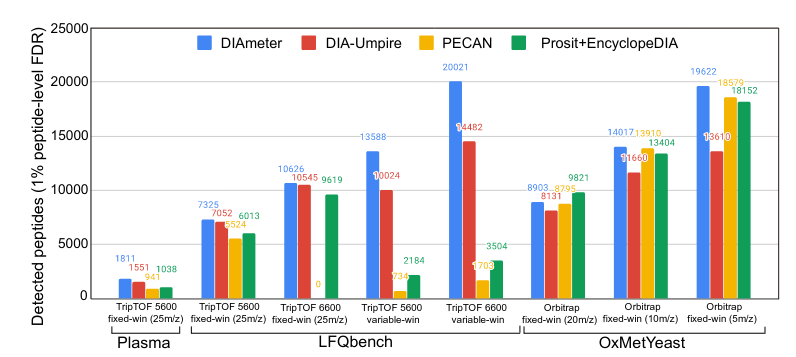

Fig. findings in DIAmeter paper.

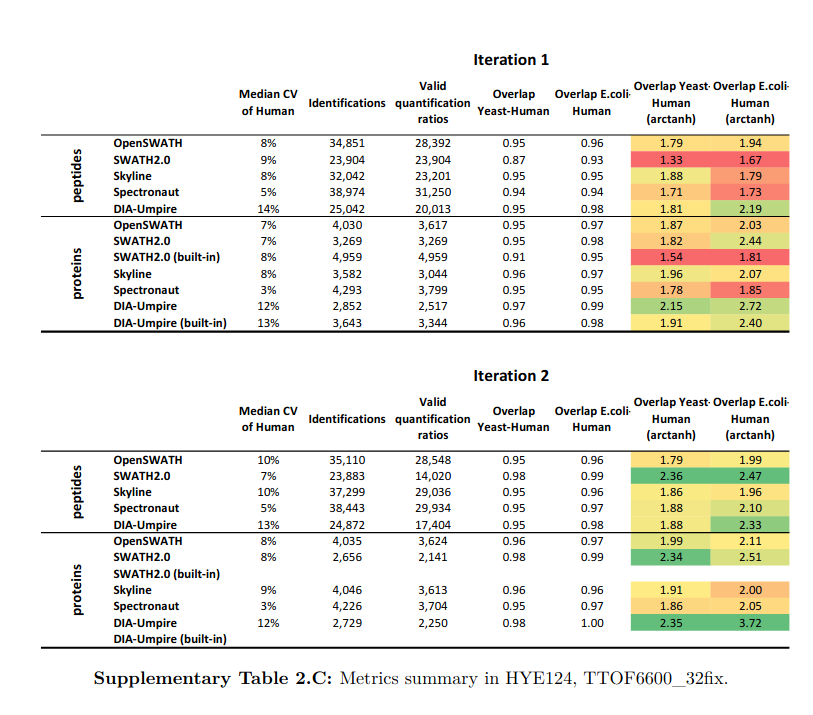

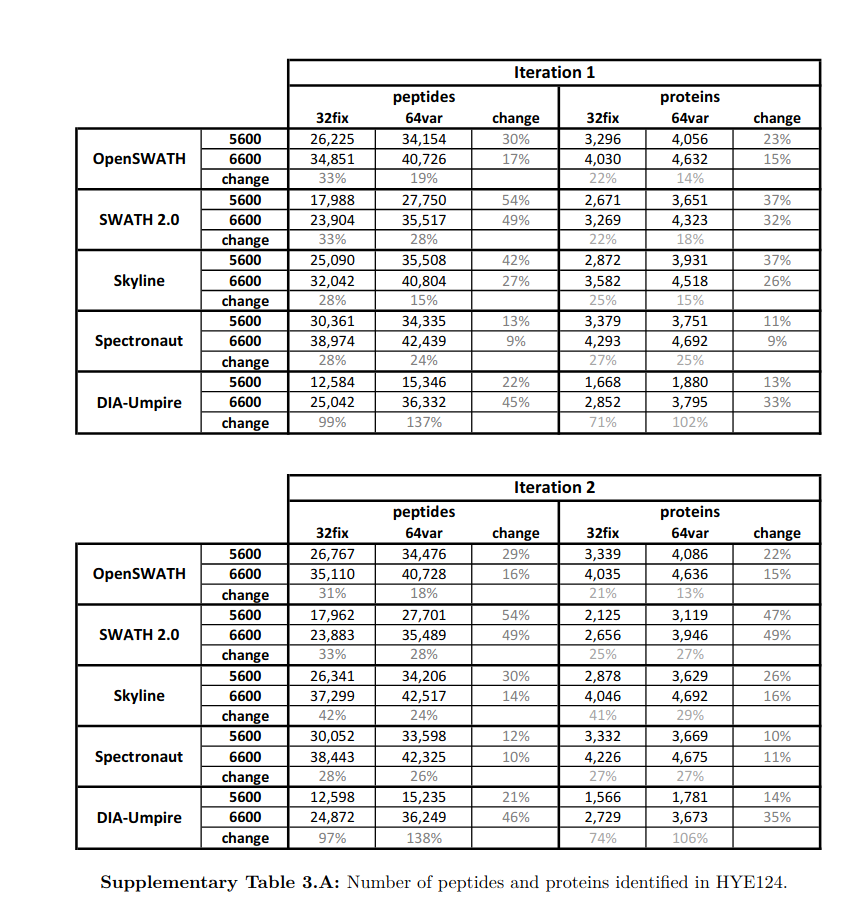

Fig. findings in LFQBench paper - Note: I believe DIA-umpire here is DIA-umpire DIA spectral library search, i.e. not the same as diann pseudo-spectra. (Check up on this).

In [189]:
df = pd.concat(dfs, axis = 1)


In [190]:
df

sample_id                     1            2            1            2  \
experiment_id         002-Pedro    003-Pedro    004-Pedro    005-Pedro   
specie ProteinName                                                       
ECOLI  P00350       1009.090667  1846.916667  1164.426667  1955.096667   
       P00363        260.452333   964.065667   296.558667  1026.736333   
       P00370         57.037300   172.192667    53.824500   190.376667   
       P00393         61.188367   188.618333    47.239733   246.371333   
       P00448         52.618650   214.905000          NaN   178.772200   
...                         ...          ...          ...          ...   
YEAS8  D3UF76        728.472667   733.410667   852.769667   743.357067   
       D3UF78         77.485200    32.077450    84.253500    39.725800   
       D3UF79        420.316667   223.233667   476.859667   252.091667   
       D3UF86               NaN          NaN          NaN          NaN   
       D3UF94       2385.933333  1273.863333  2684.723333  1357.336667   

sample_id                                  1  
experiment_id         007-Pedro    006-Pedro  
specie ProteinName                            
ECOLI  P00350       1983.450000  1194.659667  
       P00363       1037.254000   295.300667  
       P00370        200.967333    51.978133  
       P00393        263.627333    70.744167  
       P00448        183.763133    44.023667  
...                         ...          ...  
YEAS8  D3UF76        758.221667   890.583000  
       D3UF78         49.964750    89.606900  
       D3UF79        261.069667   526.239667  
       D3UF86               NaN          NaN  
       D3UF94       1430.600000  2816.886667  

[4209 rows x 6 columns]

In [191]:
df = df[df.index.get_level_values("specie").isin(["HUMAN", "ECOLI", "YEAS8"])]


In [193]:

A = df[df.iloc[:, df.columns.get_level_values("sample_id") == 1].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == 1]
#A = np.log2(A)
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == 2].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == 2]
#B = np.log2(B)

# Find overlapping proteins
overlapping_proteins = list(set(A.index) & set(B.index))
A = A[A.index.isin(overlapping_proteins)]
B = B[B.index.isin(overlapping_proteins)]

import scipy.stats as stats

p_vals = stats.ttest_ind(A, B, axis = 1)[1]
p_vals = pd.DataFrame(p_vals, columns = ["p"])
p_vals["q"] = qvalues(p_vals)
p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
p_vals.sort_values("q",inplace =True)
p_vals = p_vals.astype(float)

A = np.log2(A.sum(axis=1))
B = np.log2(B.sum(axis=1))

A.name = "1"
B.name = "2"

df_final = pd.concat([A, B, p_vals], axis = 1)
df_final["log2(A,B)"] = df_final["1"] - df_final["2"]

/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [197]:
df[df.iloc[:, df.columns.get_level_values("sample_id") == "1"].isna().sum(axis=1)<2]

sample_id                     1            2            1            2  \
experiment_id         002-Pedro    003-Pedro    004-Pedro    005-Pedro   
specie ProteinName                                                       
ECOLI  P00350       1009.090667  1846.916667  1164.426667  1955.096667   
       P00363        260.452333   964.065667   296.558667  1026.736333   
       P00370         57.037300   172.192667    53.824500   190.376667   
       P00393         61.188367   188.618333    47.239733   246.371333   
       P00448         52.618650   214.905000          NaN   178.772200   
...                         ...          ...          ...          ...   
YEAS8  D3UF74        888.638333   462.109333   981.304667   493.691000   
       D3UF76        728.472667   733.410667   852.769667   743.357067   
       D3UF78         77.485200    32.077450    84.253500    39.725800   
       D3UF79        420.316667   223.233667   476.859667   252.091667   
       D3UF94       2385.933333  1273.863333  2684.723333  1357.336667   

sample_id                                  1  
experiment_id         007-Pedro    006-Pedro  
specie ProteinName                            
ECOLI  P00350       1983.450000  1194.659667  
       P00363       1037.254000   295.300667  
       P00370        200.967333    51.978133  
       P00393        263.627333    70.744167  
       P00448        183.763133    44.023667  
...                         ...          ...  
YEAS8  D3UF74        514.087333   981.822333  
       D3UF76        758.221667   890.583000  
       D3UF78         49.964750    89.606900  
       D3UF79        261.069667   526.239667  
       D3UF94       1430.600000  2816.886667  

[3648 rows x 6 columns]

In [186]:



def pq_data(df_final, fc_treshold):
    # two-side treshold because triqler uses two side treshold.
    df_final_fc_gt = (df_final[df_final["log2(A,B)"] > fc_treshold])
    df_final_fc_lt = (df_final[df_final["log2(A,B)"] < -fc_treshold])
    df_final_fc = pd.concat([df_final_fc_gt, df_final_fc_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (df_final_fc["q"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res



import matplotlib.pyplot as plt

specie = "HUMAN"

def plot_pq(df_final, specie):
    fig, axs = plt.subplots(2, 5)
    row = 0
    col = 0
    for i in range(10):
        fc =i*0.2
        df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
        if i == 0:
            y_lim = df.max()[0]
        axs[row, col].plot(df.index, df.DE)
        axs[row, col].set_ylim([0, y_lim])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col += 1
        if col == 5:
            row +=1
            col = 0
    plt.suptitle("OSW top3 " + specie)
    plt.show()

import time
from triqler_output_to_df import  parse_triqler

os.chdir("/hdd_14T/data/PXD002952/res_20210530_DIAUmpire/MSFragger/triqler_results_20210603")

# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]

def get_pq_data_triqler(q_val):
    fc_tresh = []
    n_hs = []
    n_ye = []
    n_ec = []
    
    for file in sorted(os.listdir()):       
        fc = float(file.split("_")[1])
        df_triq = parse_triqler(file)
        # Added specie mapping... need to check the problem with BOVIN, SCVLA proteins???
        df_triq["specie"] = df_triq.protein.map(protein_specie_map)
        df_triq["protein"] = df_triq["protein"] + "_" + df_triq["specie"]
        df_triq = df_triq[df_triq["specie"].isin(["HUMAN", "ECOLI", "YEAST"])]
        df_triq = df_triq[df_triq.q_value < q_val]
        #df_triq["specie"] = df_triq.protein.map(specie_mapper)
        n_hs.append((df_triq["specie"] == "HUMAN").sum())
        n_ye.append((df_triq["specie"] == "YEAST").sum())
        n_ec.append((df_triq["specie"] == "ECOLI").sum())
        fc_tresh.append(fc)
    
    df =pd.DataFrame(np.array([n_hs, n_ye, n_ec]).T, index = fc_tresh, columns = ["HUMAN", "YEAST", "ECOLI"])
    return df


#start = time.time()
def get_DE_for_fcs(fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    qs = []
    dfs = []
    for q in np.arange(0,0.101, 0.001):
        qs.append(q)
        dfs.append(get_pq_data_triqler(q))
        #print(time.time()-start)
    end = time.time()
    #print(end-start)
    
    fcs = fcs
    fcs.sort()
    res = []
    for fc in fcs:
        vals = []
        for df in dfs:
            val = list(df[df.index == fc].values[0])
            vals.append(val)    
        df_res = pd.DataFrame(vals, index = np.arange(0,0.101, 0.001), columns = ["HUMAN", "YEAST", "ECOLI"])
        res.append(df_res)
    return res
fcs =  [round(i*0.04,2) for i in range(20)]

res = get_DE_for_fcs( fcs = fcs)

/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [188]:
df

sample_id                     1            2            1            2  \
experiment_id         002-Pedro    003-Pedro    004-Pedro    005-Pedro   
specie ProteinName                                                       
ECOLI  P00350       1009.090667  1846.916667  1164.426667  1955.096667   
       P00363        260.452333   964.065667   296.558667  1026.736333   
       P00370         57.037300   172.192667    53.824500   190.376667   
       P00393         61.188367   188.618333    47.239733   246.371333   
       P00448         52.618650   214.905000          NaN   178.772200   
...                         ...          ...          ...          ...   
YEAS8  D3UF76        728.472667   733.410667   852.769667   743.357067   
       D3UF78         77.485200    32.077450    84.253500    39.725800   
       D3UF79        420.316667   223.233667   476.859667   252.091667   
       D3UF86               NaN          NaN          NaN          NaN   
       D3UF94       2385.933333  1273.863333  2684.723333  1357.336667   

sample_id                                  1  
experiment_id         007-Pedro    006-Pedro  
specie ProteinName                            
ECOLI  P00350       1983.450000  1194.659667  
       P00363       1037.254000   295.300667  
       P00370        200.967333    51.978133  
       P00393        263.627333    70.744167  
       P00448        183.763133    44.023667  
...                         ...          ...  
YEAS8  D3UF76        758.221667   890.583000  
       D3UF78         49.964750    89.606900  
       D3UF79        261.069667   526.239667  
       D3UF86               NaN          NaN  
       D3UF94       1430.600000  2816.886667  

[4209 rows x 6 columns]

In [187]:
df_final

1    2   p    q  log2(A,B)
specie ProteinName                              
ECOLI  P00350      -inf -inf NaN  1.0        NaN
       P00363      -inf -inf NaN  1.0        NaN
       P00370      -inf -inf NaN  1.0        NaN
       P00393      -inf -inf NaN  1.0        NaN
       P00448      -inf -inf NaN  1.0        NaN
...                 ...  ...  ..  ...        ...
YEAS8  D3UF76      -inf -inf NaN  1.0        NaN
       D3UF78      -inf -inf NaN  1.0        NaN
       D3UF79      -inf -inf NaN  1.0        NaN
       D3UF86      -inf -inf NaN  1.0        NaN
       D3UF94      -inf -inf NaN  1.0        NaN

[4209 rows x 5 columns]

In [123]:

os.chdir("/hdd_14T/data/PXD002952/res_20210609_DIAUmpire/MSFragger/diann_reformatted_lib")

msqrob = pd.read_csv("msqrobsum_result_20200610.csv", sep = "\t")
msqrob["specie"] = msqrob.proteins.map(specie_mapper)

msqrob

def msqrob_pq_data(msqrob, fc):
    msqrob_gt = msqrob[msqrob.logFC > fc]
    msqrob_lt = msqrob[msqrob.logFC < -fc]
    msqrob_fc = pd.concat([msqrob_gt, msqrob_lt])
    n_array = []
    for q in np.arange(0,0.101, 0.001):
        n = (msqrob_fc["qvalue"] <= q).sum()
        n_array.append(n)
    res = pd.DataFrame(n_array, index = np.arange(0,0.101, 0.001), columns = ["DE"])
    return res


In [124]:

#Rewrite this to function subplot
def plot_pq_specie(specie, fcs =  [round(i*0.2,2) for i in range(9)] + [0.68]):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        if specie == "all":
            res[i].sum(axis=1).plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final, fc_treshold = fc)
            df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            res[i][specie].plot(ax = axs[row,col]) #triqler data plot
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)
        axs[row, col].plot(df.index, df.DE) # plot osw top3
        axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()



#Rewrite this to function subplot
def plot_pq_specie_FP(specie, fcs):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        if specie == "all":
            df = pq_data(df_final, fc_treshold = fc)
            df_triq = res[i].sum(axis=1)
            #df_ms = msstats_pq_data(ms, fc = fc)
            df_msqrob = msqrob_pq_data(msqrob, fc = fc)
        else:
            df = pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc)
            df_triq = res[i][specie]
            #df_ms = msstats_pq_data(ms[ms.specie == specie], fc = fc)
            df_msqrob = msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc)

        # False positives
        df_FP = pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc)
        df_triq_FP = res[i]["HUMAN"]
        #df_ms_FP = msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc)
        df_msqrob_FP = msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc)
        """
        if fc >= 1.0:
            df_FP_yeast = pq_data(df_final[df_final.index.get_level_values("specie") == "YEAS8"], fc_treshold = fc)
            df_triq_FP_yeast = res[i]["YEAS8"]
            df_ms_FP_yeast = msstats_pq_data(ms[ms.specie == "YEAS8"], fc = fc)
            df_msqrob_FP_yeast = msqrob_pq_data(msqrob[msqrob.specie == "YEAS8"], fc = fc)
            
            df_FP += df_FP_yeast
            df_triq_FP += df_triq_FP_yeast
            df_ms_FP += df_ms_FP_yeast
            df_msqrob_FP += df_msqrob_FP_yeast
        """ 
        df_triq.plot(ax = axs[row,col], style = "b") #triqler data plot
        axs[row, col].plot(df.index, df.DE, "k") # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob
        
        # Plot False positives
        #res[i]["HUMAN"].plot(ax = axs[row,col], style="b--") #triqler data plot
        df_triq_FP.plot(ax = axs[row, col], style="b--")
        axs[row, col].plot(df.index, df_FP.DE, "k--") # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms_FP.DE, "g--") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob_FP.DE, "r--") # plot msqrob
        

        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob",
        #                              "Triqler FP", "OSW Top3 FP", "msStats FP", "mSqRob FP" ])
        
        
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "mSqRob",
                                      "Triqler FP", "OSW Top3 FP", "mSqRob FP" ])
        
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("n - Differentially expressed.")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins {specie} ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()


#FP ratio
def plot_ratio_FP_DE(specie, fcs):
    fig, axs = plt.subplots(4, 5,figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        if specie == "all":
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final, fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i].sum(axis=1))
            #df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
            #         msstats_pq_data(ms, fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob, fc = fc))        
        else:
            df = (pq_data(df_final[df_final.index.get_level_values("specie") == "HUMAN"], fc_treshold = fc) / 
                  pq_data(df_final[df_final.index.get_level_values("specie") == specie], fc_treshold = fc))
            df_triq = (res[i]["HUMAN"] / 
                       res[i][specie])
            #df_ms = (msstats_pq_data(ms[ms.specie == "HUMAN"], fc = fc) / 
            #         msstats_pq_data(ms[ms.specie == specie], fc = fc))
            df_msqrob = (msqrob_pq_data(msqrob[msqrob.specie == "HUMAN"], fc = fc) / 
                         msqrob_pq_data(msqrob[msqrob.specie == specie], fc = fc))        

        df_triq.plot(ax = axs[row, col], style = "b") # triqler data plot
        axs[row, col].plot(df.index, df.DE, "m") # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms.DE, "g") # plot MSSTATS
        axs[row, col].plot(df_msqrob.index, df_msqrob.DE, "r") # plot msqrob

        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob", ])
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "mSqRob", ])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel("q-value")
        axs[row, col].set_ylabel("ratio FP/DE - Differentially expressed.")
        
        def abline(slope, intercept, row, col):
            """Plot a line from slope and intercept"""
            axes = plt.gca()
            x_vals = np.array(axs[row,col].get_xlim())
            y_vals = intercept + slope * x_vals
            axs[row,col].plot(x_vals, y_vals, 'k--', alpha = 0.7)
        abline(1,0,row,col)
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Ratio FP / Differentially expressed proteins ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()




#Rewrite this to function subplot
def plot_de_specie_xy(specie_x, specie_y, fcs):
    fig, axs = plt.subplots(4, 5, figsize=(20,15))
    row = 0
    col = 0
    #specie = "ECOLI"
    fcs = fcs
    fcs.sort()
    for i in range(20):
        fc = fcs[i]
        
        df_triq_x = res[i][specie_x]
        df_x = pq_data(df_final[df_final.index.get_level_values("specie") == specie_x], fc_treshold = fc)
        #df_ms_x = msstats_pq_data(ms[ms.specie == specie_x], fc = fc)
        df_msqrob_x = msqrob_pq_data(msqrob[msqrob.specie == specie_x], fc = fc)
        
        df_triq_y = res[i][specie_y]
        df_y = pq_data(df_final[df_final.index.get_level_values("specie") == specie_y], fc_treshold = fc)
        #df_ms_y = msstats_pq_data(ms[ms.specie == specie_y], fc = fc)
        df_msqrob_y = msqrob_pq_data(msqrob[msqrob.specie == specie_y], fc = fc)
        
        #df_triq_x.plot(ax = axs[row,col]) #triqler data plot        
        #axs[row, col].plot(df.index, df.DE) # plot osw top3
        #axs[row, col].plot(df_ms.index, df_ms.DE) # plot MSSTATS
        #axs[row, col].plot(df_msqrob.index, df_msqrob.DE) # plot msqrob
        
        axs[row, col].plot(df_triq_x.values, df_triq_y.values)
        axs[row, col].plot(df_x.values, df_y.values)
        #axs[row, col].plot(df_ms_x.values, df_ms_y.values)
        axs[row, col].plot(df_msqrob_x.values, df_msqrob_y.values)
        
        #axs[row, col].legend(labels=["Triqler", "OSW Top3", "msStats", "mSqRob"])
        axs[row, col].legend(labels=["Triqler", "OSW Top3", "mSqRob"])
        axs[row, col].set_title(f"fc = {fc}")
        axs[row, col].set_xlabel(f"n - Differentially expressed {specie_x}")
        axs[row, col].set_ylabel(f"n - Differentially expressed {specie_y}")
        col+=1
        if col == 5:
            row+=1
            col=0
    plt.suptitle(f"Differentially expressed proteins specie ratio ( True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )")# + specie)
    plt.show()

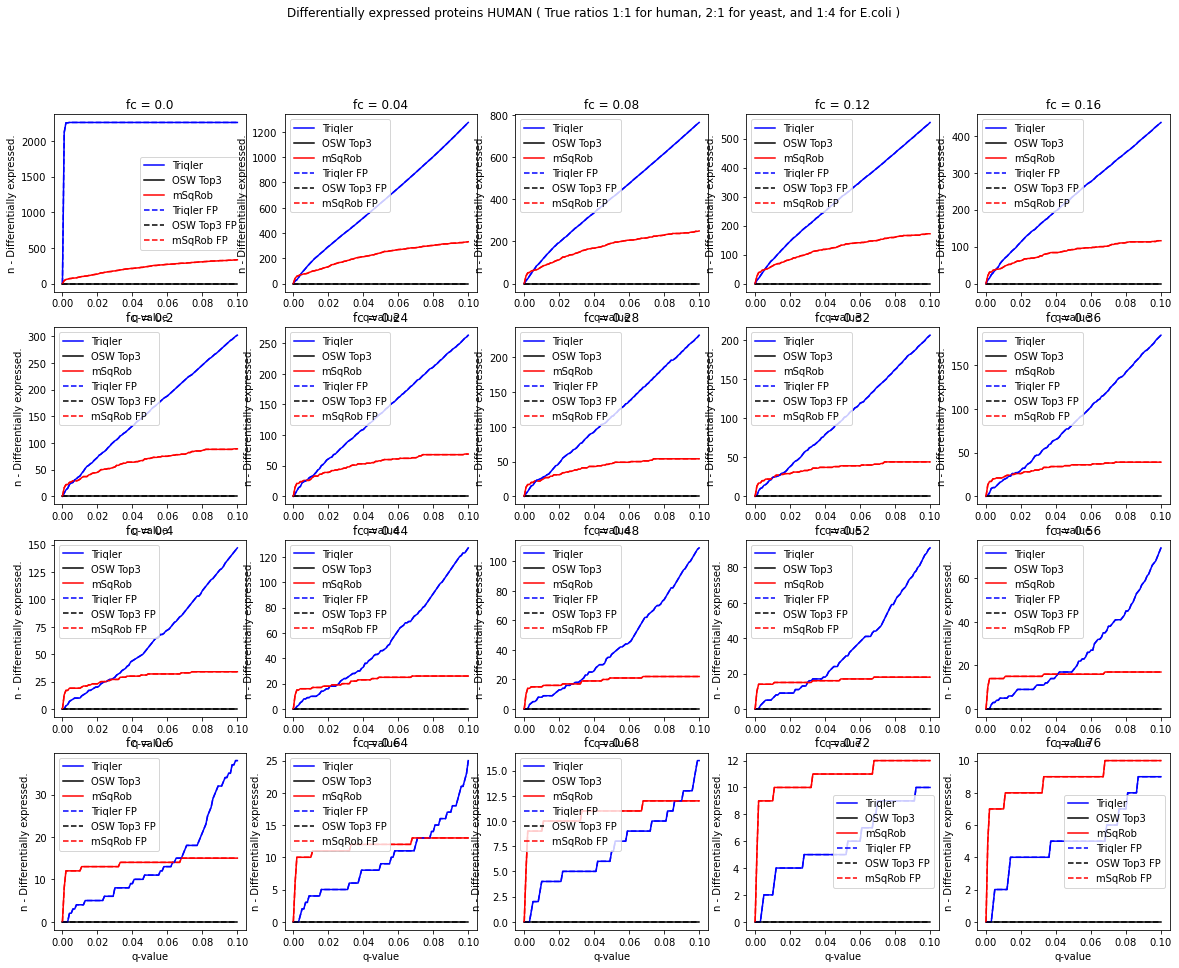

In [125]:
plot_pq_specie_FP(specie = "HUMAN", fcs = fcs)


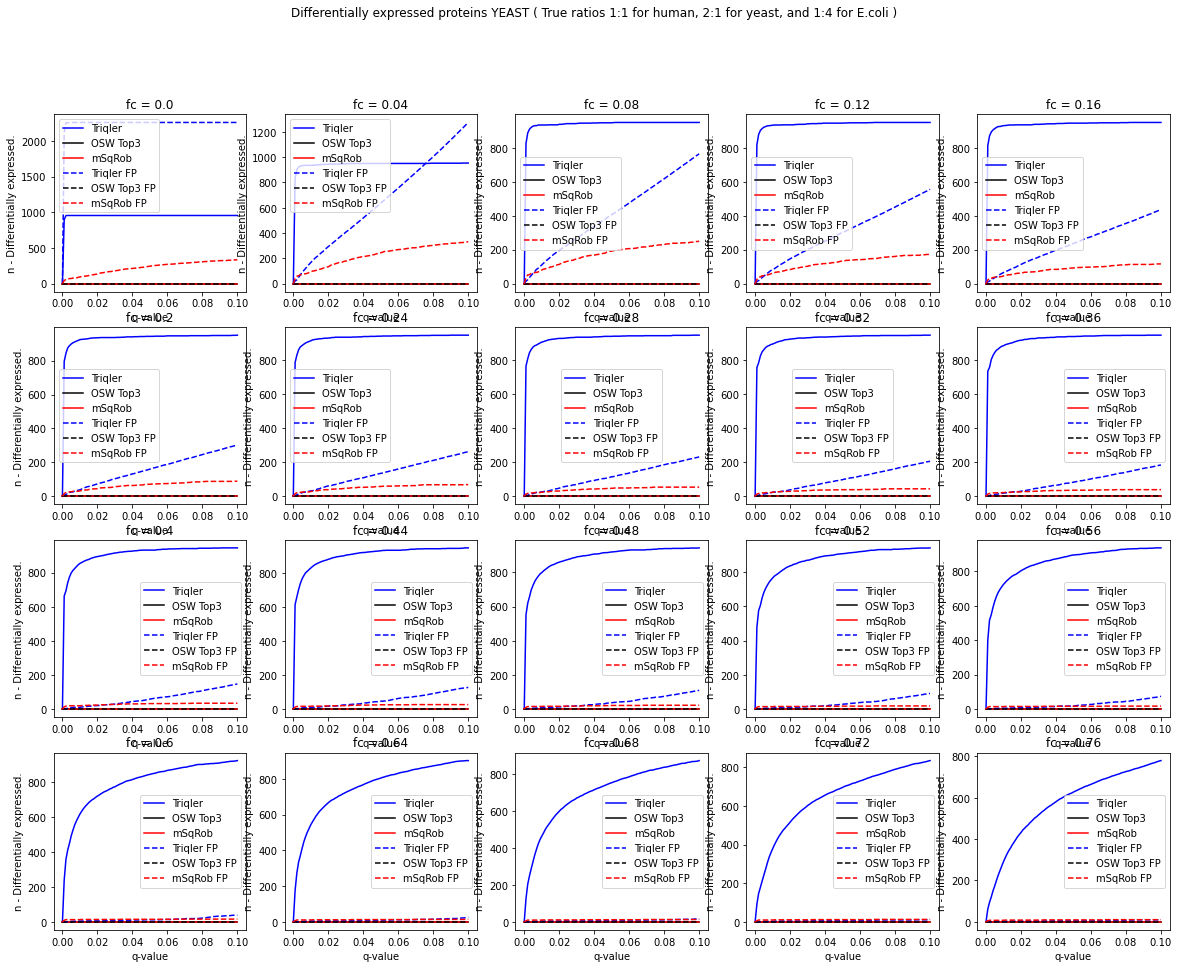

In [126]:
plot_pq_specie_FP(specie = "YEAST", fcs = fcs)


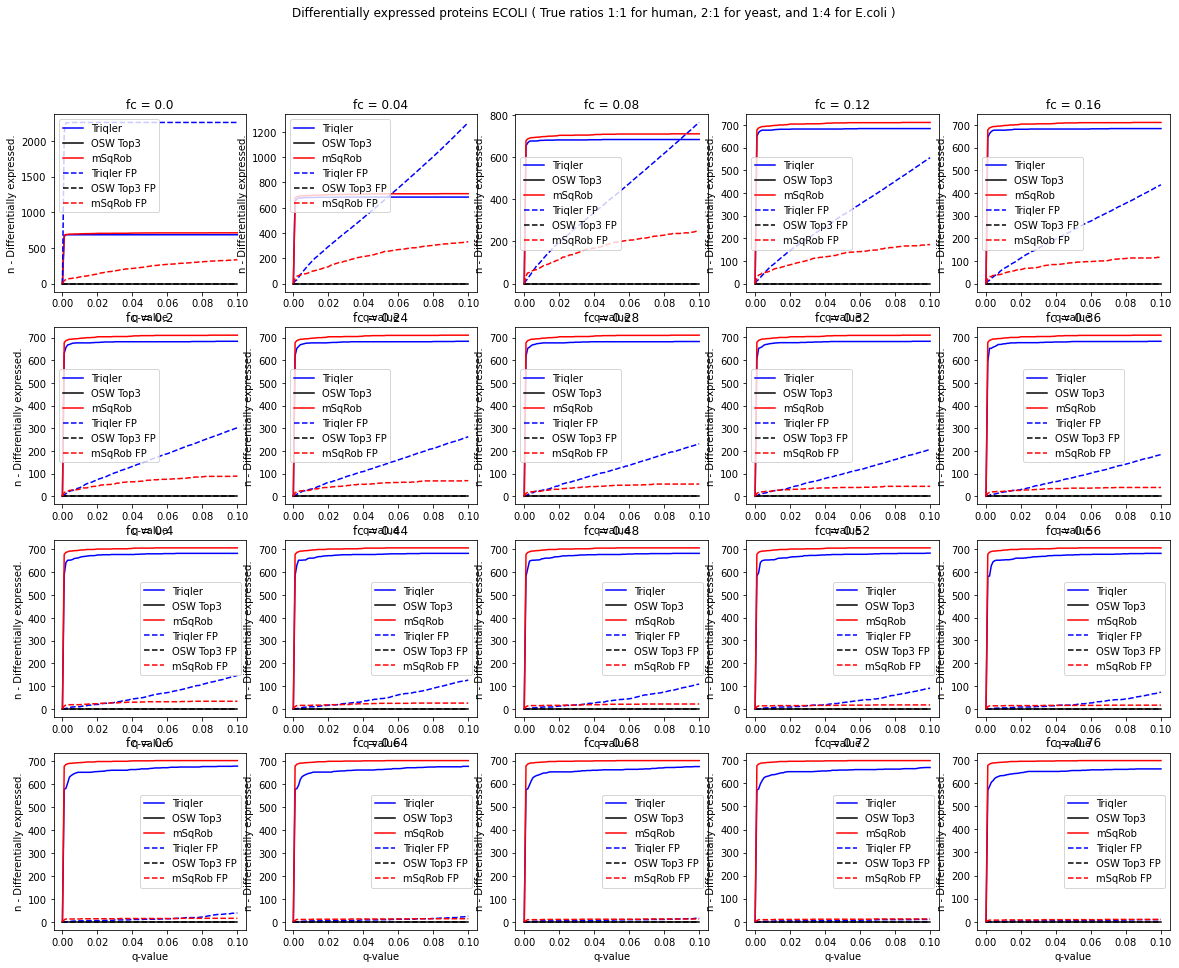

In [127]:
plot_pq_specie_FP(specie = "ECOLI", fcs = fcs)


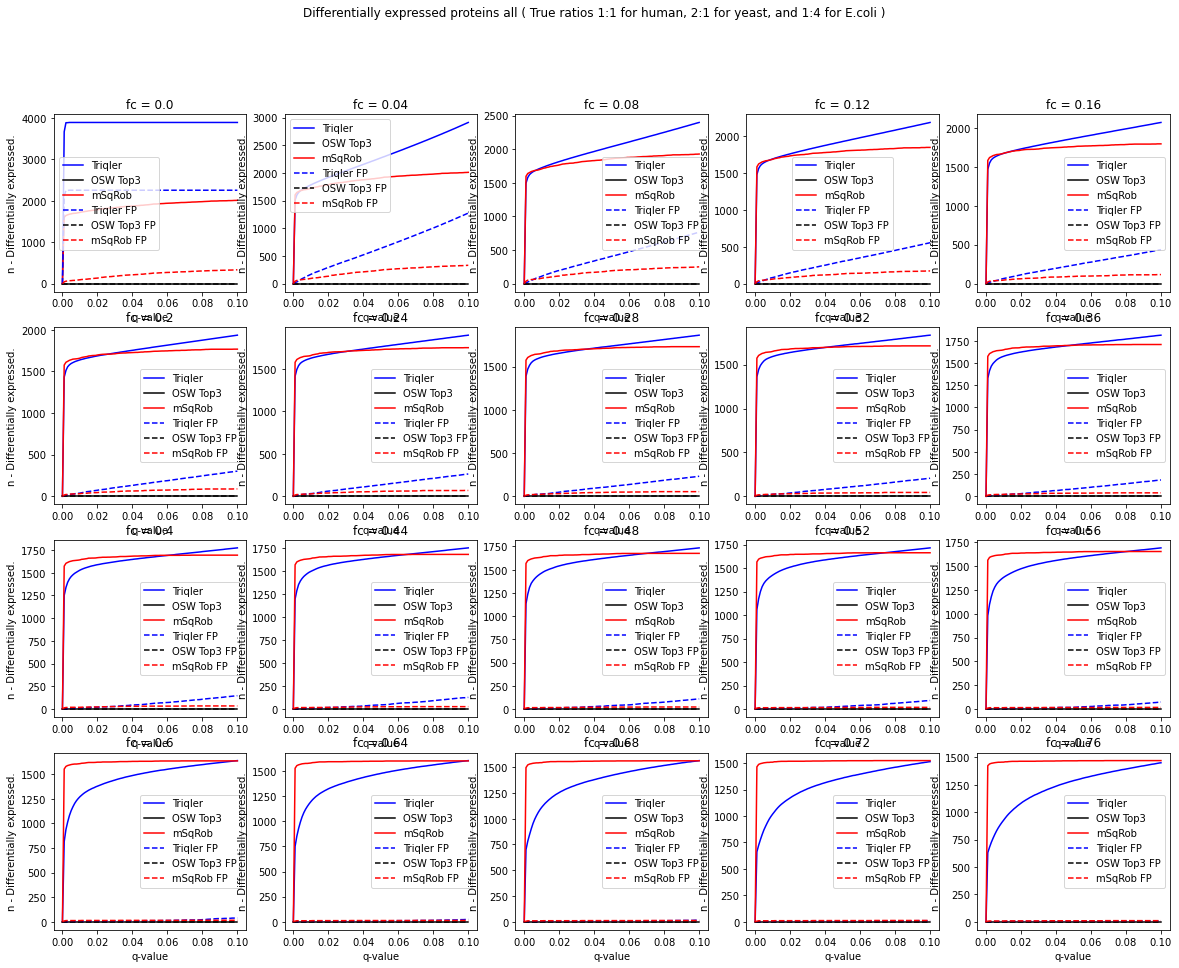

In [128]:
plot_pq_specie_FP(specie = "all", fcs = fcs)

# FP / DE ratio - Calibration plot

### FP is defined as DE-human proteins, DE is for DE for all species.

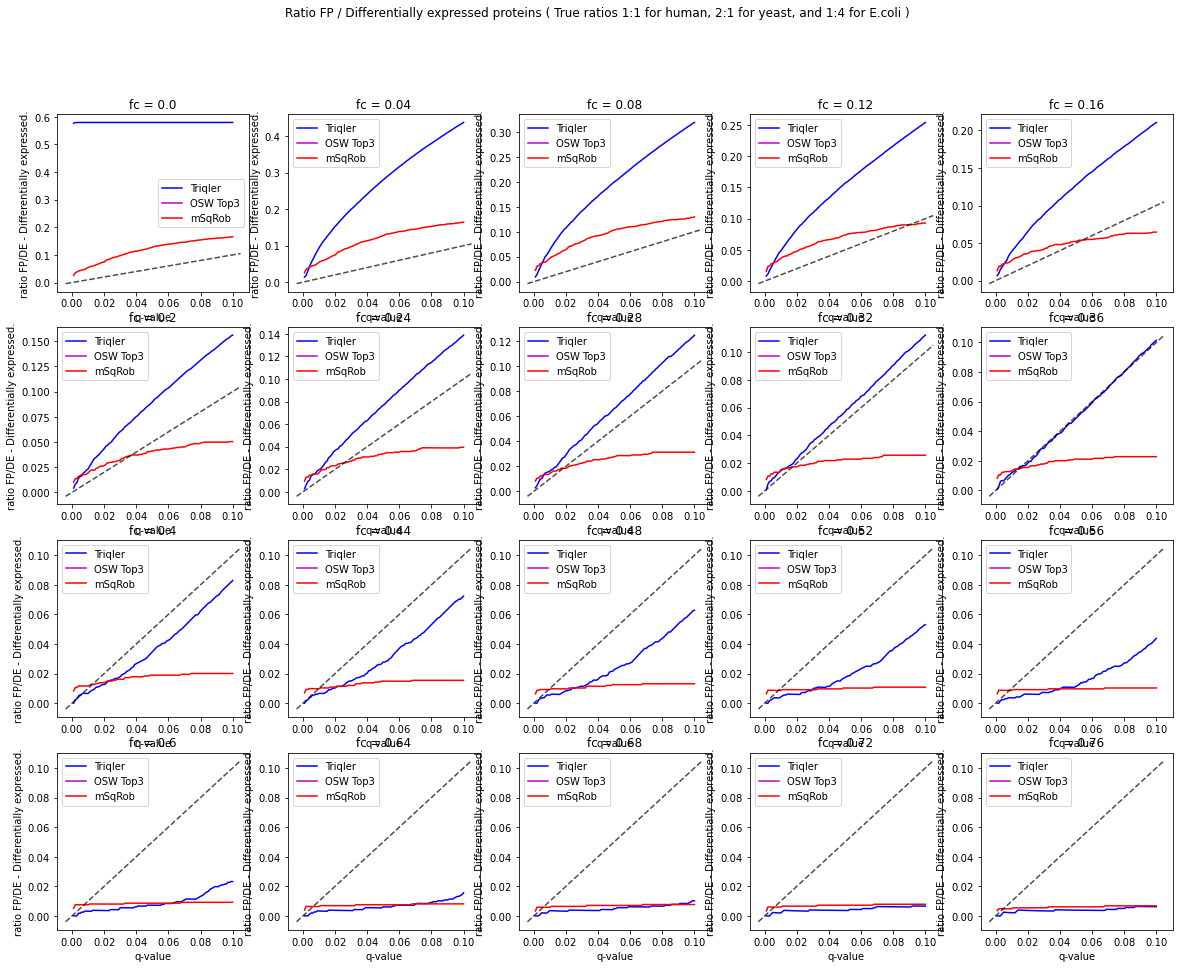

In [130]:
plot_ratio_FP_DE(specie = "all", fcs = fcs)

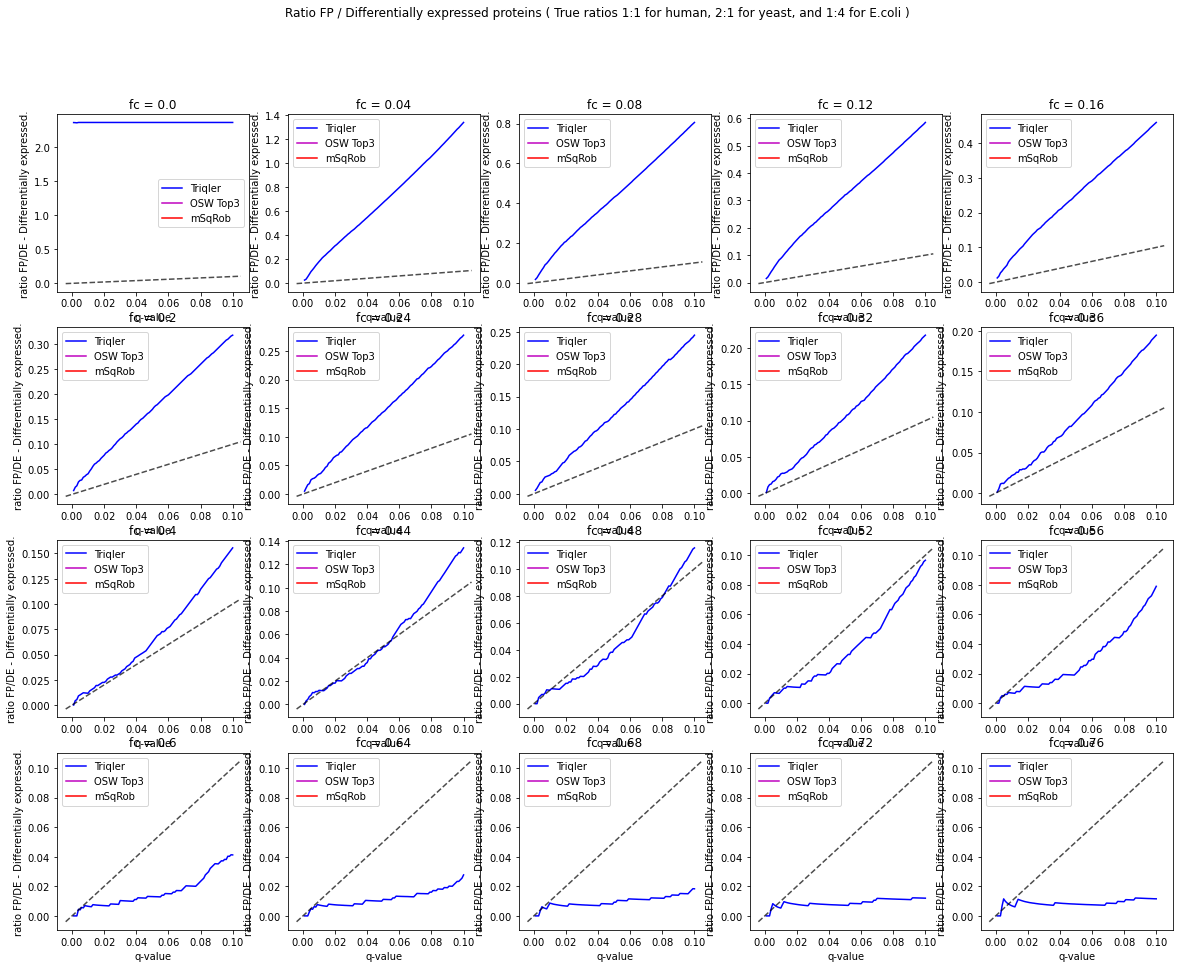

In [131]:
plot_ratio_FP_DE(specie = "YEAST", fcs = fcs)

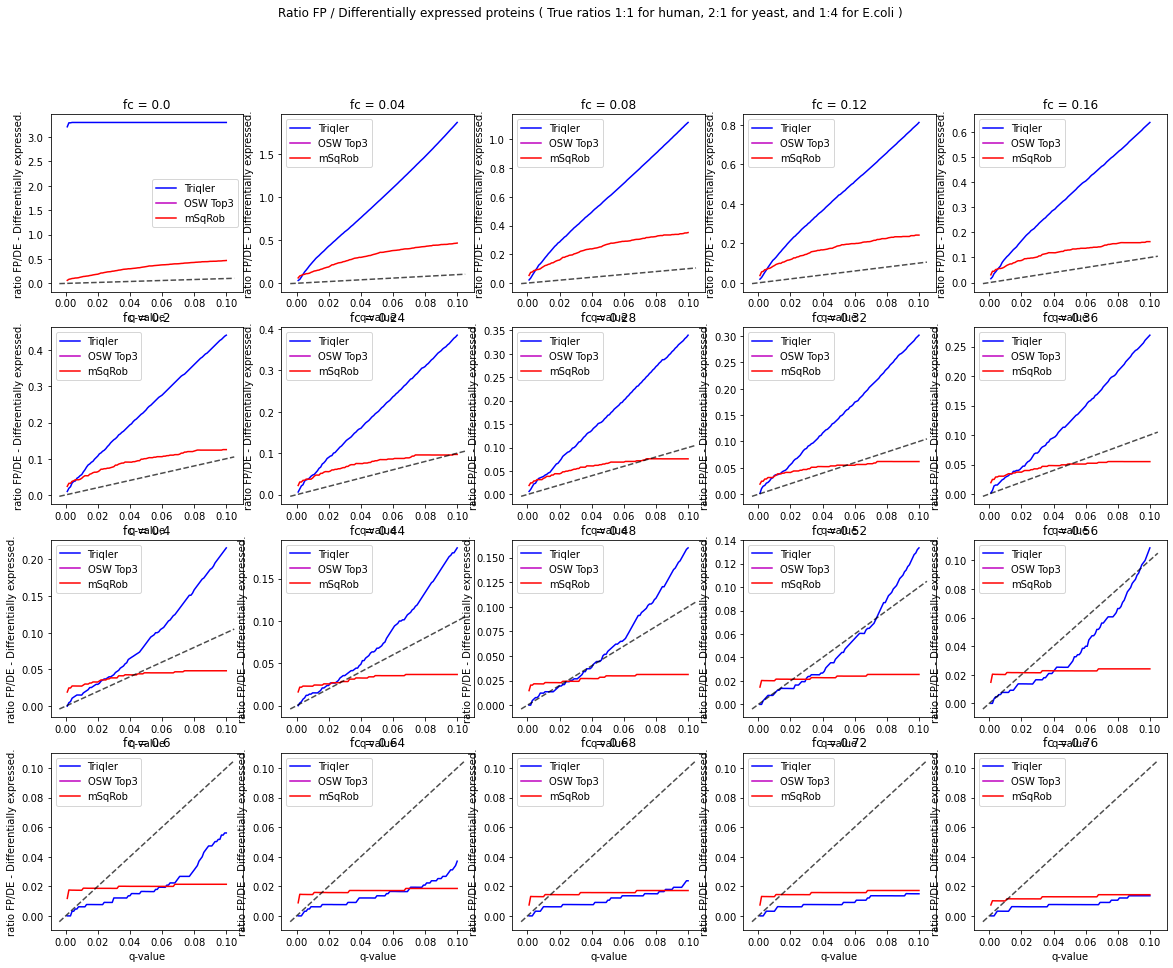

In [132]:
plot_ratio_FP_DE(specie = "ECOLI", fcs = fcs)

In [133]:
# DE YEAST or ECOLI as a function of DE HUMAN

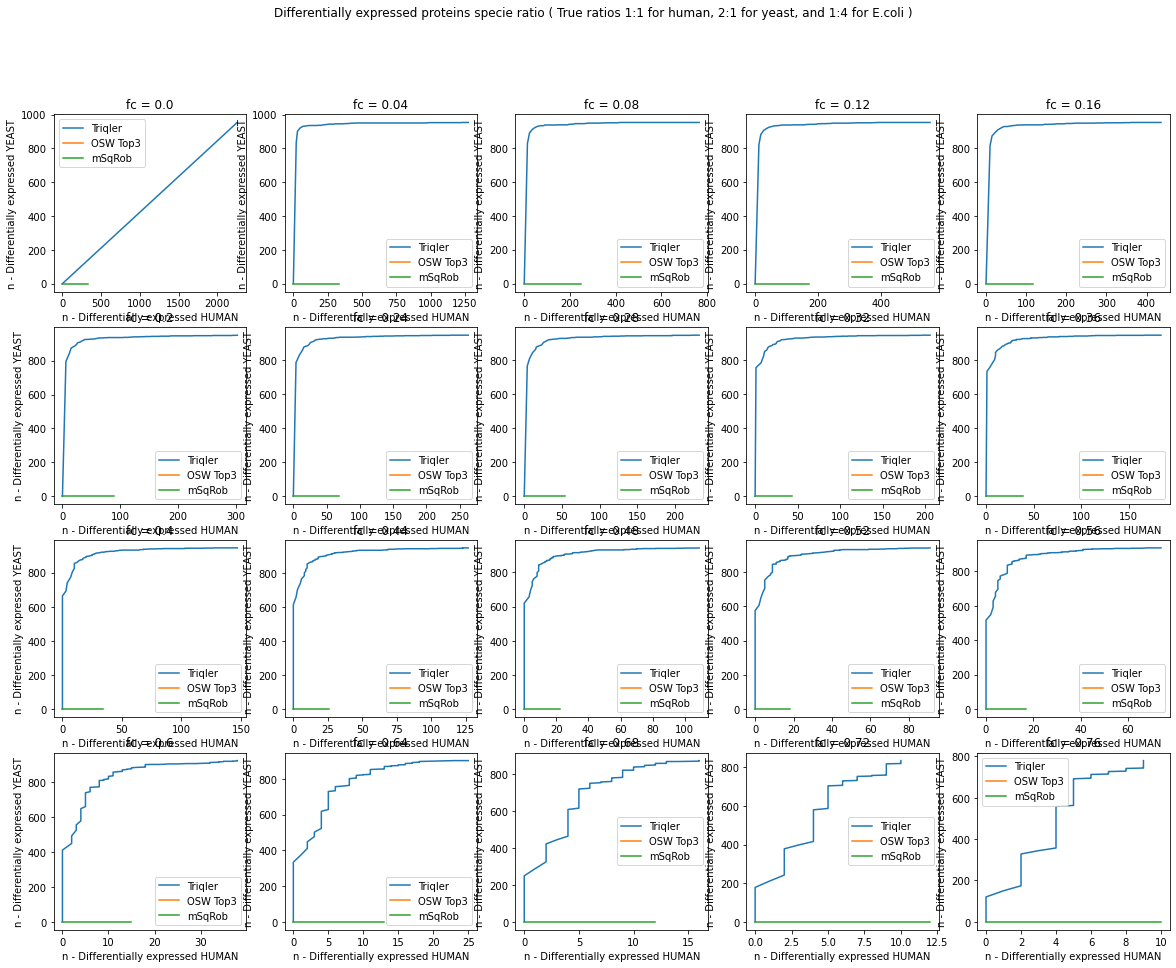

In [134]:
plot_de_specie_xy(specie_x = "HUMAN",specie_y = "YEAST", fcs = fcs)


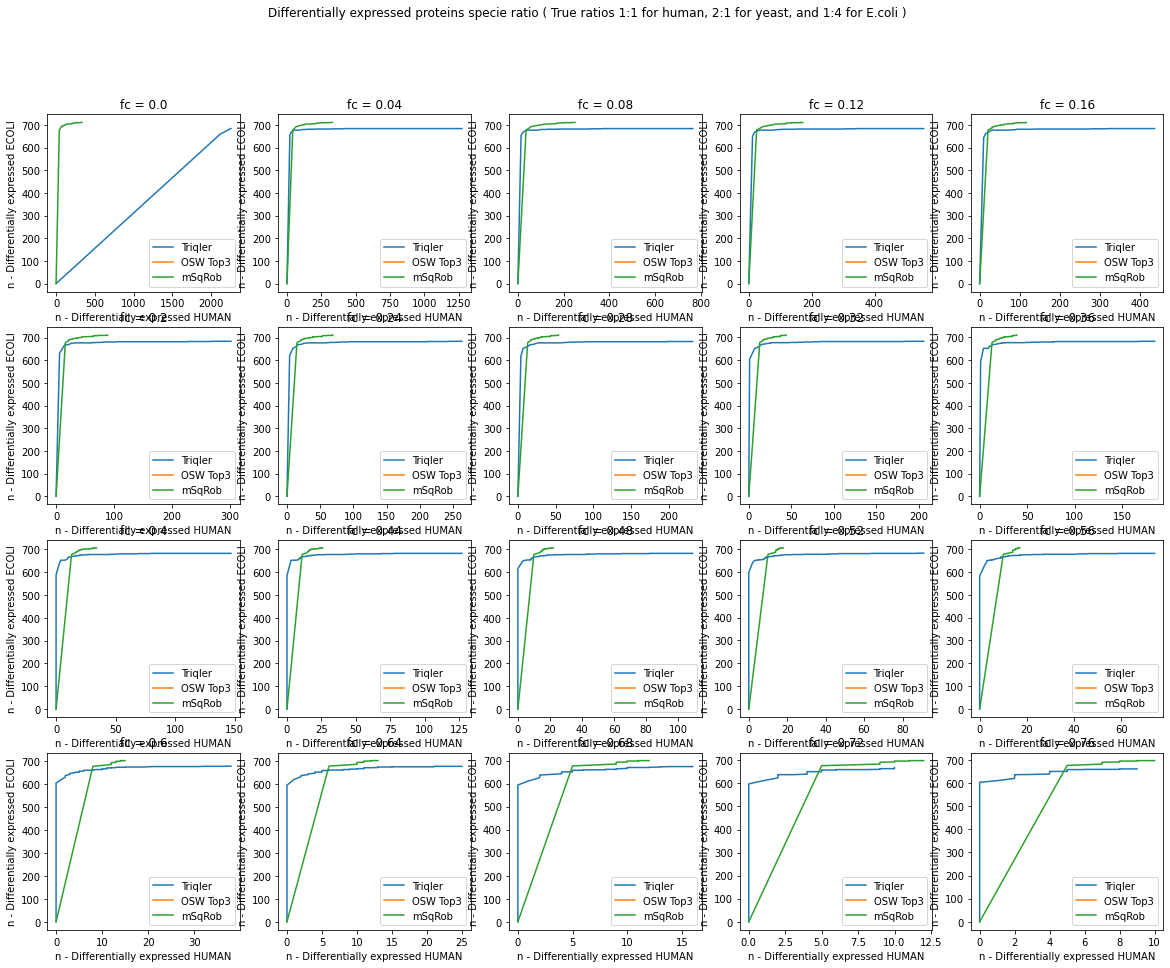

In [135]:
plot_de_specie_xy(specie_x = "HUMAN",specie_y = "ECOLI", fcs = fcs)

# Distributions of log2FC

### Note that the log2FC are not q-value tresholded

In [139]:
import seaborn as sns

In [137]:
df_final = df_final[df_final.index.get_level_values("specie").isin(["ECOLI", "YEAST", "HUMAN"])]
df_final.replace([np.inf, -np.inf], np.nan, inplace=True)

/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/home/ptruong/anaconda3/envs/py37/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, 'Top3 log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )')

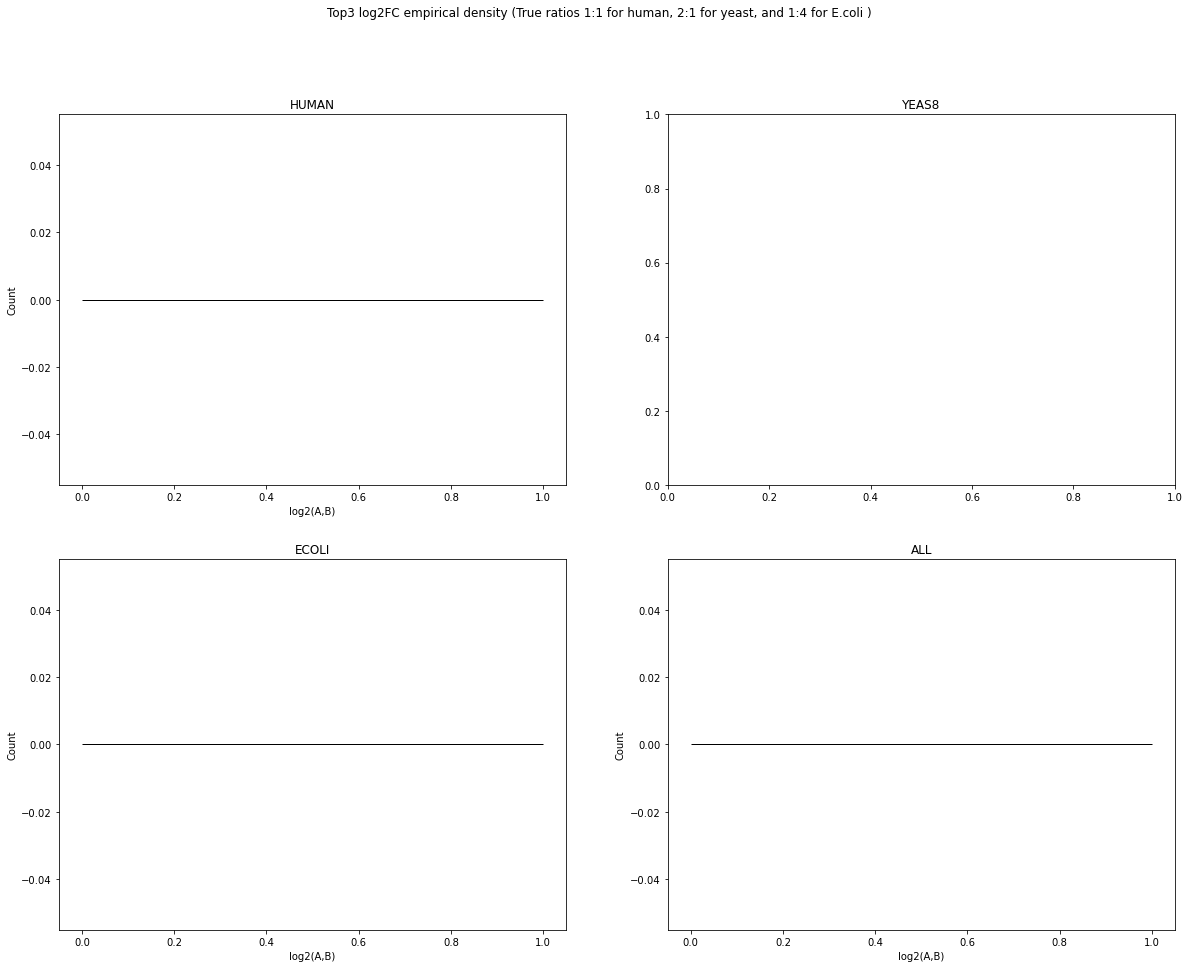

In [140]:
fig, axs = plt.subplots(2, 2, figsize=(20,15))
sns.histplot(df_final[df_final.index.get_level_values("specie")=="HUMAN"]["log2(A,B)"], kde = True, ax = axs[0,0])
axs[0,0].set_title("HUMAN")  
sns.histplot(df_final[df_final.index.get_level_values("specie")=="YEAST"]["log2(A,B)"], kde = True, ax = axs[0,1])
axs[0,1].set_title("YEAS8")  
sns.histplot(df_final[df_final.index.get_level_values("specie")=="ECOLI"]["log2(A,B)"], kde = True, ax = axs[1,0])
axs[1,0].set_title("ECOLI")
sns.histplot(df_final["log2(A,B)"], kde = False, ax = axs[1,1])
axs[1,1].set_title("ALL")
sns.histplot(data=df_final, x="log2(A,B)", hue="specie", multiple="stack", kde = True)
fig.suptitle('Top3 log2FC empirical density (True ratios 1:1 for human, 2:1 for yeast, and 1:4 for E.coli )') 

In [145]:
df_final.index.get_level_values("specie").unique()

Index(['ECOLI', 'HUMAN'], dtype='object', name='specie')